# Hardware

i3-6100 (3.7GHz x 2, hyper-threaded), 32G memory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import scipy.signal as signal
from PIL import Image
from tqdm import tqdm
from numba import jit
import pyfftw
import multiprocessing
nthread = multiprocessing.cpu_count()

# Read samples and transfer to complex iq datasets

In [2]:
# read the raw iq data
b4filename = '4_V.bin'
Fs = 2.048e6
F0 = 202.93e6

#Open the file in binary read mode    
with open(b4filename, "rb") as f:
    data = np.fromfile(f, dtype='int8')

In [3]:
# Turn the interleaved I and Q samples into complex values
# the syntax "dat[0::2]" means "every 2nd value in 
# array dat starting from the 0th until the end"
iq_dat = 1.0*data[0::2] + 1j*data[1::2]
NSAMP = len(iq_dat)

# generate time coordinates
dt = 1.0/Fs
tim = np.arange(0, dt*NSAMP, dt)

Now we have three parameters:

1. Fs    : sample rate
2. F0    : center frequency
3. NSAMP : number of samples 

# Plot the raw data

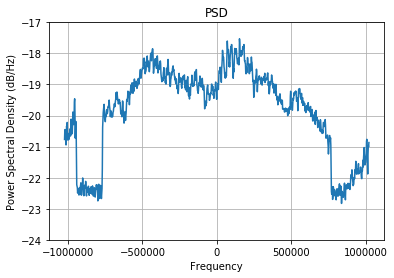

In [4]:
FFTLEN = 1024*1024
FFTSTAT = 0*1024
# PSD of the whole dataset
plt.psd(iq_dat[FFTSTAT:FFTSTAT+FFTLEN], NFFT=1024, Fs=int(Fs))
plt.title("PSD")
plt.show() 

Two additional parameters:

1. FFTLEN  : length of the samples in each coherent time
2. FFTSTAT : starting point of the samples for each coherent time

# Ambiguity function 

We need more paramters to produce the range-dopple plot

1. Vmax       :   maximum speed (Vmin decide by F0/Fs and FFTLEN)
2. Rmax       :   maximum range (Rmin decided by Fs)

In [5]:
# doppler space
Vmax = 400                          # maximum speed required (km/h)
Vmin = 3e8/(F0/Fs)*3.6/FFTLEN       # speed resolution (km/h)
Ndop = int(Vmax/Vmin)               # number of points in dopple space
Ddop = Fs/FFTLEN                    # frequency resolution in dopple space
Mdop = Ddop*Ndop                    # maximum frequency in dopple space
dop = np.arange(-Mdop, Mdop, Ddop)  # dopple space 

In [6]:
# range space
Rmax = 30                           # maximum range
Rmin = (3e8/Fs)/1000                # range resolution (km)
Nrng = int(Rmax/Rmin)               # number of points in range space
tau  = np.arange(-Rmax, Rmax, Rmin) # range space

In [ ]:
def amb_self(sig, tim):
    """This function calculate the (self) ambiguity function from the signal 'sig' """
    nn = len(sig)  # length of the signal 
    amb = np.zeros((Nrng, 2*Ndop), dtype = complex)
    for im in range(2*Ndop):
        mes_sig = sig*np.exp( 2.0*1j*np.pi*tim*dop[im] )
        tmp_amb = signal.correlate(sig, mes_sig, mode='same')           # use raw scipy correlate
        amb[:, im] = tmp_amb[(nn//2-Nrng//2):(nn//2+Nrng//2)] #/float(nn)
    return amb

In [ ]:
# check a specific case
FFTSTAT = 100*1024
sig1 = iq_dat[FFTSTAT:FFTSTAT+FFTLEN]
tim1 = tim[FFTSTAT:FFTSTAT+FFTLEN]
%time aamm = amb_self(sig1, tim1)  # check the running time
# create mesh grid for ambiguity function
X, Y = np.meshgrid(dop, tau)
am = np.abs(aamm)
Z = am

In [ ]:
plt.matshow(am[2:Nrng//2-1, :])
#plt.imshow(am[0:Nrng//2-1, :], interpolation='none', cmap='gray', aspect='auto', extent=[-Mdop, Mdop, Rmin, Rmax])

In [ ]:
# We can plot the data in range-velocity space
plt.imshow(am[0:Nrng//2-1, :], interpolation='nearest', cmap='gray', aspect='auto', extent=[-Vmax, Vmax, Rmin, Rmax])

# Ambiguity function calculation in Frequency domain

In [ ]:
# # Let us profile the function amb_self with %prun magic
# FFTSTAT = 100*1024
# sig1 = iq_dat[FFTSTAT:FFTSTAT+FFTLEN]
# tim1 = tim[FFTSTAT:FFTSTAT+FFTLEN]
# %prun -s cumulative amb_self(sig1, tim1)  # check the running time

In [ ]:
# %load_ext line_profiler

In [ ]:
# %lprun -f amb_self amb_self(sig1, tim1)

In [ ]:
# import numpy.fft

# def correlate_fft(a, b):
#     """Return circular correlation of two one-dimensional arrays."""
#     # forward DFT
#     a = numpy.fft.fft(a)
#     b = numpy.fft.fft(b)
#     # multiply by complex conjugate
#     a *= b.conj()
#     # reverse DFT
#     c = numpy.fft.ifft(a)
#     # shift
#     #c = numpy.fft.fftshift(c)
#     return c

In [ ]:
# def amb_self_fft1(sig, tim):
#     """This function calculate the (self) ambiguity function from the signal 'sig' """
#     nn = len(sig)  # length of the signal 
#     amb = np.zeros((Nrng, 2*Ndop), dtype = complex)
#     for im in range(2*Ndop):
#         mes_sig = sig*np.exp( 2.0*1j*np.pi*tim*dop[im] )
#         #tmp_amb = signal.correlate(sig, mes_sig, mode='same')           # use raw scipy correlate
#         tmp_amb = correlate_fft(sig, mes_sig)
#         #amb[:, im] = tmp_amb[(nn//2-Nrng//2):(nn//2+Nrng//2)] #/float(nn)
#         amb[:, im] = tmp_amb[0:Nrng] #/float(nn)
#     return amb

In [ ]:
# # check a specific case
# FFTSTAT = 100*1024
# sig1 = iq_dat[FFTSTAT:FFTSTAT+FFTLEN]
# tim1 = tim[FFTSTAT:FFTSTAT+FFTLEN]
# %time aamm = amb_self_fft1(sig1, tim1)  # check the running time
# # create mesh grid for ambiguity function
# X, Y = np.meshgrid(dop, tau)
# am = np.abs(aamm)
# Z = am

In [ ]:
# #plt.matshow(am[4:Nrng//2, :])
# plt.matshow(am[2:Nrng, :])

In [7]:
# now let us calculate the ambiguity function in frequency domain
def amb_self_fft(sig):
    """This function calculate the (self) ambiguity function from the signal 'sig' """ 
    sig_fft = np.fft.fft(sig)   # signal in frequency domain
    nn = len(sig_fft)            # length of the signal
    amb = np.zeros((Nrng, 2*Ndop), dtype = complex)
    for im in range(2*Ndop):
        tmp_amb = np.roll(sig_fft, im-Ndop)*np.conj(sig_fft)
        tmp_amb = np.fft.ifft(tmp_amb)
        amb[:, im] = tmp_amb[0:Nrng]
    return amb

In [11]:
# check a specific case
FFTSTAT = 100*1024
sig1 = iq_dat[FFTSTAT:FFTSTAT+FFTLEN]
%time aamm = amb_self_fft(sig1)  # check the running time
# create mesh grid for ambiguity function
X, Y = np.meshgrid(dop, tau)
am = np.log( np.abs(aamm) )
Z = am

CPU times: user 3.81 s, sys: 492 ms, total: 4.3 s
Wall time: 4.3 s


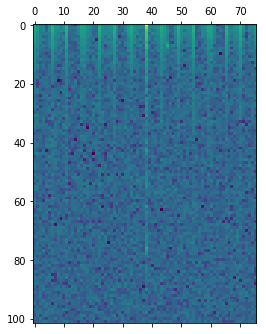

In [12]:
#plt.matshow(am[4:Nrng//2, Ndop+1:2*Ndop])
plt.matshow(am[0:Nrng//2, :])
# this time, we get more than two times faster than 'amb_self'

In [13]:
# fftw version
def amb_self_fftw(sig):
    """This function calculate the (self) ambiguity function from the signal 'sig' """
    # first perform the fft for the signal: sig
    nn = len(sig)
    sig_fftw = pyfftw.interfaces.numpy_fft.fft(sig)
    
    # perform the 2d fft via fftw
    a = pyfftw.empty_aligned((2*Ndop, nn), dtype='complex')
    b = pyfftw.empty_aligned((2*Ndop, nn), dtype='complex')    
    # Plan an fft over the last axis
    #ifft_object_a = pyfftw.FFTW(a, b, direction='FFTW_BACKWARD', flags=('FFTW_MEASURE', ), threads=nthread, planning_timelimit=None)
    ifft_object_a = pyfftw.FFTW(a, b, direction='FFTW_BACKWARD', flags=('FFTW_MEASURE', ), threads=nthread, planning_timelimit=None)
    # generate the 2d array contains doppler shift information
    for im in range(2*Ndop):
        a[im, :] = np.roll(sig_fftw, im-Ndop)*np.conj(sig_fftw)
    ifft_object_a()
    
    # extract the range-doppler information
    amb = np.zeros((Nrng, 2*Ndop), dtype = complex)
    for im in range(2*Ndop):
        amb[:, im] = b[im, 0:Nrng]        
    return amb

In [16]:
# check a specific case
FFTSTAT = 100*1024
sig1 = iq_dat[FFTSTAT:FFTSTAT+FFTLEN]
%time aamm = amb_self_fftw(sig1)  # check the running time
am = np.log( np.abs(aamm) )

CPU times: user 3.85 s, sys: 204 ms, total: 4.06 s
Wall time: 1.85 s


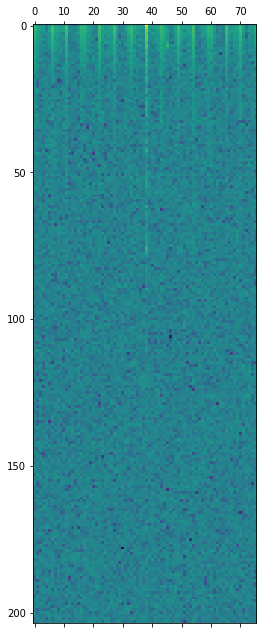

In [17]:
#plt.matshow(am[4:Nrng//2, Ndop+1:2*Ndop])
plt.matshow(am[:, :])
# there are overhand in the first run 7s, then it goes to 1.7s

# Create range-dopple plot with ambiguity function

In [18]:
# create gif figure
NT = int(NSAMP/FFTLEN)
snapshots = []
for nt in tqdm(range(NT)):
    FFTSTAT = nt*FFTLEN
    sig1 = iq_dat[FFTSTAT:FFTSTAT+FFTLEN]
    aamm = amb_self_fftw(sig1)
    am = np.log( np.abs(aamm) )
    snapshots.append(am)
    #print(nt)

100%|██████████| 58/58 [01:57<00:00,  2.03s/it]


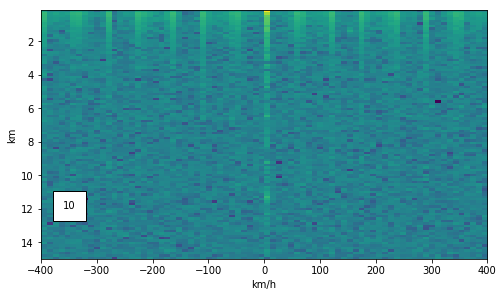

In [20]:
#a = snapshots[10][2:Nrng//2-1, :]
#a = snapshots[10][2:Nrng//2-1, Ndop+1:]
a = snapshots[10][:Nrng//2, :]
fig = plt.figure( figsize=(8,8) )
plt.xlabel("km/h")
plt.ylabel("km")
text_it = 10
plt.text(-Vmax+(Ndop/10)*Vmin, Rmax//2-(Nrng/10)*Rmin, text_it, bbox={'facecolor': 'white', 'pad': 10})
plt.imshow(a, interpolation='nearest', aspect=30, extent=[-Vmax, Vmax, Rmax//2, Rmin])

............Done!
.

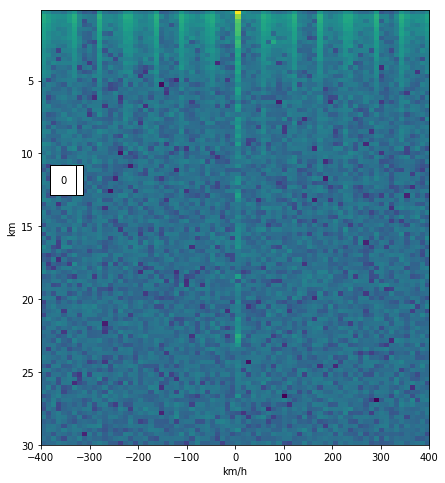

In [21]:
fps = 5
nSeconds = NT//fps

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )
plt.xlabel("km/h")
plt.ylabel("km")

#a = snapshots[0][2:Nrng//2-1, :]
a = snapshots[0][:Nrng//2, :]

#im = plt.imshow(a, interpolation='nearest', cmap='gray', aspect=30, extent=[-Vmax, Vmax, Rmin, Rmax])
im = plt.imshow(a, interpolation='nearest', aspect=30, extent=[-Vmax, Vmax, Rmax, Rmin])

text_it = 0
plt.text(-Vmax+(Ndop/10)*Vmin, Rmax//2-(Nrng/10)*Rmin, text_it, bbox={'facecolor': 'white', 'pad': 10})

def animate_func(i):
    #print(i)
    if i % fps == 0:
        print( '.', end ='' )
    text_it = i
    plt.text(-Vmax+(Ndop/10)*Vmin, Rmax//2-(Nrng/10)*Rmin, text_it, bbox={'facecolor': 'white', 'pad': 10})
    #im.set_array(snapshots[i][2:Nrng//2-1, :])
    im.set_array(snapshots[i][0:Nrng//2, :])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('passive_radar.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

# plt.show()  # Not required, it seems!